In [1]:
%matplotlib inline
import cv2
import warnings
import torch
import matplotlib.pyplot as plt
import numpy as np
import config as cfg
from dataset import (get_cornell_grasp_ids, get_cornell_id_meta, cornell_grasp_id2realpath,
                    parse_pcl, pc2depth, parse_bbox, normalize_depth, parse_img)
from models import GraspModel
from utils import (center_crop, preprocess_input,feature2bboxwdeg)
import inference

In [2]:
import random
import time
random.seed(int(time.time())%20000)
np.random.seed(int(time.time())%20000)

In [3]:
ids = sorted(get_cornell_grasp_ids())
meta, class2id, obj2id = get_cornell_id_meta()

In [4]:
#img_p, pcl_p, pos_p, neg_p = cornell_grasp_id2realpath(ids[np.random.choice(len(ids))])[:4]
#img_p, pcl_p, pos_p, neg_p = cornell_grasp_id2realpath('0325')[:4]

In [5]:
def fetch_by_id(id_):
    img_p, pcl_p, pos_p, neg_p = cornell_grasp_id2realpath(id_)[:4]
    img = parse_img(img_p)
    pts, idx = parse_pcl(pcl_p)
    depth = pc2depth(pts, idx, size=img.shape[:2])
    real_bbox = parse_bbox(pos_p)
    return img, depth, real_bbox

In [6]:
img, depth, real_bbox = fetch_by_id('0325')

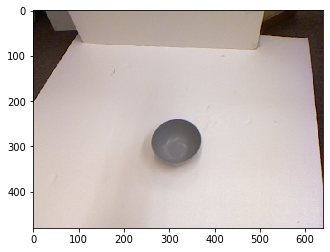

In [7]:
plt.imshow(img)
plt.show()

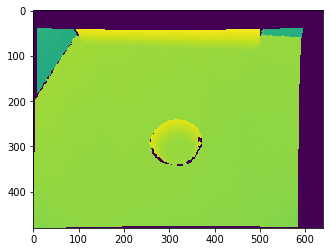

In [8]:
plt.imshow((depth-depth.min()) / (depth.max()-depth.min()))
plt.show()

In [9]:
rgd, dim = inference.preprocess_raw(img, depth)

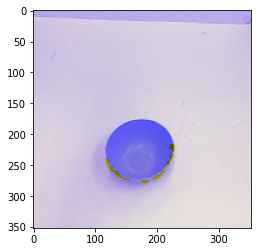

In [10]:
plt.imshow(rgd*np.array([[[0.229, 0.224, 0.225]]], dtype=np.float32)+np.array([[[0.485, 0.456, 0.406]]], dtype=np.float32))
plt.show()

In [11]:
model = GraspModel(backbone='vgg19_bn', with_fc=False).cpu()
#state_dict = torch.load('../reimplement/obj_split_weights/w-f01.pth', map_location='cpu')
state_dict = torch.load('./weights/w-f01.pth', map_location='cpu')
#state_dict = torch.load('./weights/w-f02.pth', map_location='cpu')
model.load_state_dict(state_dict, strict=False)
state_dict['val_accuracy']

0.5916870415503255

In [12]:
bboxes, degs, confs = inference.inference_bbox(model, rgd[np.newaxis])
bboxes, degs, confs = bboxes[0], degs[0], confs[0]

In [13]:
print(bboxes, degs, confs)

[[[0.5647034  0.6246615 ]
  [0.6949481  0.66613364]
  [0.6693937  0.746388  ]
  [0.53914905 0.70491576]]

 [[0.3437288  0.7907231 ]
  [0.40396306 0.68738866]
  [0.47173783 0.726895  ]
  [0.41150358 0.8302294 ]]

 [[0.5371456  0.70520395]
  [0.5500641  0.8316368 ]
  [0.46499255 0.8403291 ]
  [0.45207405 0.7138963 ]]] [-0.30826673  1.0430409  -1.4689729 ] [0.09445661 0.32717285 0.7512293 ]


In [14]:
best_idx = np.argmax(confs)

In [15]:
best_bbox, best_degs = bboxes[best_idx], degs[best_idx]

In [16]:
proposed_bbox = inference.bbox_postprocess(best_bbox, dim)

In [17]:
proposed_bbox

array([[333.07526, 312.2318 ],
       [337.62256, 356.73615],
       [307.67737, 359.79584],
       [303.13007, 315.2915 ]], dtype=float32)

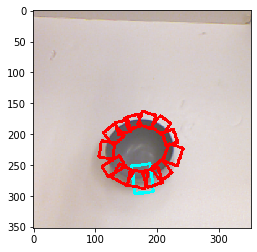

In [18]:
img_with_bbox = np.copy(img[...,::-1])
cv2.polylines(img_with_bbox, [np.round(proposed_bbox).astype(np.int32)], True, (255, 255, 0), 4)
cv2.polylines(img_with_bbox, np.round(real_bbox).astype(np.int32), True, (0, 0, 255), 4)
img_with_bbox = img_with_bbox[...,::-1]
plt.imshow(center_crop(img_with_bbox, crop_size=cfg.crop_size))
plt.show()

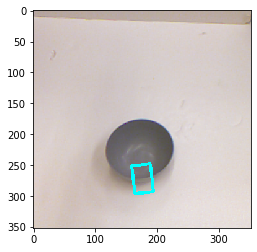

In [19]:
img_with_bbox = np.copy(img[...,::-1])
cv2.polylines(img_with_bbox, [np.round(proposed_bbox).astype(np.int32)], True, (255, 255, 0), 4)
#cv2.polylines(img_with_bbox, np.round(real_bbox).astype(np.int32), True, (0, 0, 255), 4)
img_with_bbox = img_with_bbox[...,::-1]
plt.imshow(center_crop(img_with_bbox, crop_size=cfg.crop_size))
plt.show()

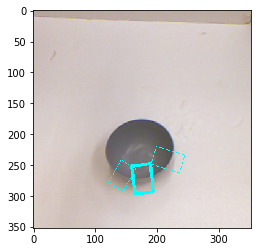

In [20]:
img_with_bbox = np.copy(img[...,::-1])
for x,c in zip(bboxes, confs):
    y = inference.bbox_postprocess(x, dim) 
    cv2.polylines(img_with_bbox, [np.round(np.asarray(y)).astype(np.int32)], True, (255, 255, 0), int(5*c))
img_with_bbox = img_with_bbox[...,::-1]
plt.imshow(center_crop(img_with_bbox, crop_size=cfg.crop_size))
plt.show()

In [21]:
img2, depth2, real2 = fetch_by_id('0326')

In [22]:
bboxes, degs, confs = inference.predict(model, [img,img2], [depth,depth2], 0)

In [23]:
bboxes

[[array([[338.15717, 271.79913],
         [362.47763, 251.413  ],
         [378.39334, 270.40027],
         [354.07288, 290.78644]], dtype=float32),
  array([[343.4189 , 283.1623 ],
         [384.9629 , 300.88702],
         [374.11243, 326.31882],
         [332.56845, 308.59406]], dtype=float32),
  array([[332.46942, 312.31995],
         [338.33038, 353.42535],
         [308.64185, 357.65848],
         [302.78088, 316.55307]], dtype=float32)],
 [array([[264.2781 , 347.17578],
         [284.492  , 310.46808],
         [309.37625, 324.1711 ],
         [289.16235, 360.87885]], dtype=float32),
  array([[330.69452, 318.1745 ],
         [336.4995 , 359.61768],
         [307.05988, 363.74133],
         [301.25488, 322.29813]], dtype=float32)]]

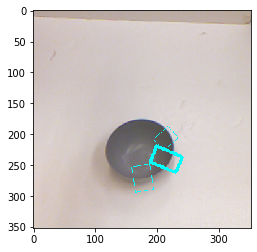

In [24]:
img_with_bbox = np.copy(img[...,::-1])
for x,c in zip(bboxes[0], confs[0]):
    cv2.polylines(img_with_bbox, [np.round(np.asarray(x)).astype(np.int32)], True, (255, 255, 0), int(5*c))
img_with_bbox = img_with_bbox[...,::-1]
plt.imshow(center_crop(img_with_bbox, crop_size=cfg.crop_size))
plt.show()

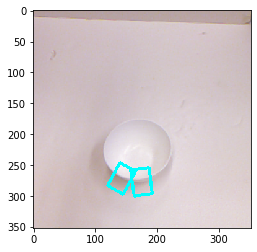

In [25]:
img_with_bbox = np.copy(img2[...,::-1])
for x,c in zip(bboxes[1], confs[1]):
    cv2.polylines(img_with_bbox, [np.round(np.asarray(x)).astype(np.int32)], True, (255, 255, 0), int(5*c))
img_with_bbox = img_with_bbox[...,::-1]
plt.imshow(center_crop(img_with_bbox, crop_size=cfg.crop_size))
plt.show()